In [1]:
# !wget http://baidudeeplearning.bj.bcebos.com/image_contest_level_1.tar.gz
# !tar -zxf image_contest_level_1.tar.gz

In [2]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.transform import resize as imresize
import cv2
import time

/home/husein/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/husein/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/husein/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/husein/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: 

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
directory = 'image_contest_level_1/'
images = ['%d.png'%(d) for d in range(100000)]
with open(directory+'labels.txt','r') as fopen:
    labels = [i.split()[0] for i in list(filter(None,fopen.read().split('\n')))]
len(images)
len(labels)

100000

In [5]:
charset = list(set(''.join(labels)))
num_classes = len(charset) + 2
encode_maps = {}
decode_maps = {}
for i, char in enumerate(charset, 3):
    encode_maps[char] = i
    decode_maps[i] = char
    
SPACE_INDEX = 0
SPACE_TOKEN = '<PAD>'
encode_maps[SPACE_TOKEN] = SPACE_INDEX
decode_maps[SPACE_INDEX] = SPACE_TOKEN

GO_INDEX = 1
GO_TOKEN = '<GO>'
encode_maps[GO_TOKEN] = GO_INDEX
decode_maps[GO_INDEX] = GO_TOKEN

EOS_INDEX = 2
EOS_TOKEN = '<EOS>'
encode_maps[EOS_TOKEN] = EOS_INDEX
decode_maps[EOS_INDEX] = EOS_TOKEN

In [6]:
GO = 1
PAD = 0
EOS = 2

In [7]:
image_height = 60
image_width = 240
image_channel = 1
max_stepsize = 128
num_hidden = 256
epoch = 20
batch_size = 128
initial_learning_rate = 1e-3

In [8]:
from tqdm import tqdm

X, Y = [], []
for i in tqdm(range(len(images))):
    img = images[i]
    X.append(imresize(cv2.imread(directory+img, 0).astype(np.float32)/255., (image_height,image_width)))
    Y.append([encode_maps[c] for c in labels[i]] + [2])

100%|██████████| 100000/100000 [02:42<00:00, 614.11it/s]


In [9]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size = 0.2)

In [10]:
[decode_maps[c] for c in Y[-1]]

['5', '-', '5', '*', '1', '<EOS>']

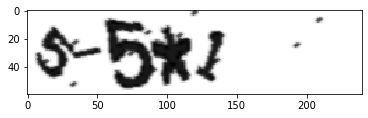

In [11]:
plt.imshow(X[-1], cmap = 'gray')

In [12]:
# https://github.com/guillaumegenthial/im2latex/blob/master/model/components/attention_mechanism.py

class AttentionMechanism(object):
    """Class to compute attention over an image"""

    def __init__(self, img, dim_e, tiles=1):
        """Stores the image under the right shape.
        We loose the H, W dimensions and merge them into a single
        dimension that corresponds to "regions" of the image.
        Args:
            img: (tf.Tensor) image
            dim_e: (int) dimension of the intermediary vector used to
                compute attention
            tiles: (int) default 1, input to context h may have size
                    (tile * batch_size, ...)
        """
        if len(img.shape) == 3:
            self._img = img
        elif len(img.shape) == 4:
            N    = tf.shape(img)[0]
            H, W = tf.shape(img)[1], tf.shape(img)[2] # image
            C    = img.shape[3].value                 # channels
            self._img = tf.reshape(img, shape=[N, H*W, C])
        else:
            print("Image shape not supported")
            raise NotImplementedError

        # dimensions
        self._n_regions  = tf.shape(self._img)[1]
        self._n_channels = self._img.shape[2].value
        self._dim_e      = dim_e
        self._tiles      = tiles
        self._scope_name = "att_mechanism"

        # attention vector over the image
        self._att_img = tf.layers.dense(
            inputs=self._img,
            units=self._dim_e,
            use_bias=False,
            name="att_img")


    def context(self, h):
        """Computes attention
        Args:
            h: (batch_size, num_units) hidden state
        Returns:
            c: (batch_size, channels) context vector
        """
        with tf.variable_scope(self._scope_name):
            if self._tiles > 1:
                att_img = tf.expand_dims(self._att_img, axis=1)
                att_img = tf.tile(att_img, multiples=[1, self._tiles, 1, 1])
                att_img = tf.reshape(att_img, shape=[-1, self._n_regions,
                        self._dim_e])
                img = tf.expand_dims(self._img, axis=1)
                img = tf.tile(img, multiples=[1, self._tiles, 1, 1])
                img = tf.reshape(img, shape=[-1, self._n_regions,
                        self._n_channels])
            else:
                att_img = self._att_img
                img     = self._img

            # computes attention over the hidden vector
            att_h = tf.layers.dense(inputs=h, units=self._dim_e, use_bias=False)

            # sums the two contributions
            att_h = tf.expand_dims(att_h, axis=1)
            att = tf.tanh(att_img + att_h)

            # computes scalar product with beta vector
            # works faster with a matmul than with a * and a tf.reduce_sum
            att_beta = tf.get_variable("att_beta", shape=[self._dim_e, 1],
                    dtype=tf.float32)
            att_flat = tf.reshape(att, shape=[-1, self._dim_e])
            e = tf.matmul(att_flat, att_beta)
            e = tf.reshape(e, shape=[-1, self._n_regions])

            # compute weights
            a = tf.nn.softmax(e)
            a = tf.expand_dims(a, axis=-1)
            c = tf.reduce_sum(a * img, axis=1)

            return c


    def initial_cell_state(self, cell):
        """Returns initial state of a cell computed from the image
        Assumes cell.state_type is an instance of named_tuple.
        Ex: LSTMStateTuple
        Args:
            cell: (instance of RNNCell) must define _state_size
        """
        _states_0 = []
        for hidden_name in cell._state_size._fields:
            hidden_dim = getattr(cell._state_size, hidden_name)
            h = self.initial_state(hidden_name, hidden_dim)
            _states_0.append(h)

        initial_state_cell = type(cell.state_size)(*_states_0)

        return initial_state_cell


    def initial_state(self, name, dim):
        """Returns initial state of dimension specified by dim"""
        with tf.variable_scope(self._scope_name):
            img_mean = tf.reduce_mean(self._img, axis=1)
            W = tf.get_variable("W_{}_0".format(name), shape=[self._n_channels,
                    dim])
            b = tf.get_variable("b_{}_0".format(name), shape=[dim])
            h = tf.tanh(tf.matmul(img_mean, W) + b)

            return h

In [13]:
# https://github.com/guillaumegenthial/im2latex/blob/master/model/components/attention_cell.py

import collections
from tensorflow.contrib.rnn import RNNCell, LSTMStateTuple


AttentionState = collections.namedtuple("AttentionState", ("cell_state", "o"))


class AttentionCell(RNNCell):
    def __init__(self, cell, attention_mechanism, dropout, dim_e,
                 dim_o, num_units,
        num_proj, dtype=tf.float32):
        """
        Args:
            cell: (RNNCell)
            attention_mechanism: (AttentionMechanism)
            dropout: (tf.float)
            attn_cell_config: (dict) hyper params
        """
        # variables and tensors
        self._cell                = cell
        self._attention_mechanism = attention_mechanism
        self._dropout             = dropout

        # hyperparameters and shapes
        self._n_channels     = self._attention_mechanism._n_channels
        self._dim_e          = dim_e
        self._dim_o          = dim_o
        self._num_units      = num_units
        self._num_proj       = num_proj
        self._dtype          = dtype

        # for RNNCell
        self._state_size = AttentionState(self._cell._state_size, self._dim_o)


    @property
    def state_size(self):
        return self._state_size


    @property
    def output_size(self):
        return self._num_proj


    @property
    def output_dtype(self):
        return self._dtype


    def initial_state(self):
        """Returns initial state for the lstm"""
        initial_cell_state = self._attention_mechanism.initial_cell_state(self._cell)
        initial_o          = self._attention_mechanism.initial_state("o", self._dim_o)

        return AttentionState(initial_cell_state, initial_o)


    def step(self, embedding, attn_cell_state):
        """
        Args:
            embedding: shape = (batch_size, dim_embeddings) embeddings
                from previous time step
            attn_cell_state: (AttentionState) state from previous time step
        """
        prev_cell_state, o = attn_cell_state

        scope = tf.get_variable_scope()
        with tf.variable_scope(scope):
            # compute new h
            x                     = tf.concat([embedding, o], axis=-1)
            new_h, new_cell_state = self._cell.__call__(x, prev_cell_state)
            new_h = tf.nn.dropout(new_h, self._dropout)

            # compute attention
            c = self._attention_mechanism.context(new_h)

            # compute o
            o_W_c = tf.get_variable("o_W_c", dtype=tf.float32,
                    shape=(self._n_channels, self._dim_o))
            o_W_h = tf.get_variable("o_W_h", dtype=tf.float32,
                    shape=(self._num_units, self._dim_o))

            new_o = tf.tanh(tf.matmul(new_h, o_W_h) + tf.matmul(c, o_W_c))
            new_o = tf.nn.dropout(new_o, self._dropout)

            y_W_o = tf.get_variable("y_W_o", dtype=tf.float32,
                    shape=(self._dim_o, self._num_proj))
            logits = tf.matmul(new_o, y_W_o)

            # new Attn cell state
            new_state = AttentionState(new_cell_state, new_o)

            return logits, new_state


    def __call__(self, inputs, state):
        """
        Args:
            inputs: the embedding of the previous word for training only
            state: (AttentionState) (h, o) where h is the hidden state and
                o is the vector used to make the prediction of
                the previous word
        """
        new_output, new_state = self.step(inputs, state)

        return (new_output, new_state)

In [14]:
from __future__ import division
import math
import numpy as np
from six.moves import xrange
import tensorflow as tf


# taken from https://github.com/tensorflow/tensor2tensor/blob/37465a1759e278e8f073cd04cd9b4fe377d3c740/tensor2tensor/layers/common_attention.py

# taken from https://raw.githubusercontent.com/guillaumegenthial/im2latex/master/model/components/positional.py

def add_timing_signal_nd(x, min_timescale=1.0, max_timescale=1.0e4):
    """Adds a bunch of sinusoids of different frequencies to a Tensor.

    Each channel of the input Tensor is incremented by a sinusoid of a difft
    frequency and phase in one of the positional dimensions.

    This allows attention to learn to use absolute and relative positions.
    Timing signals should be added to some precursors of both the query and the
    memory inputs to attention.

    The use of relative position is possible because sin(a+b) and cos(a+b) can
    be experessed in terms of b, sin(a) and cos(a).

    x is a Tensor with n "positional" dimensions, e.g. one dimension for a
    sequence or two dimensions for an image

    We use a geometric sequence of timescales starting with
    min_timescale and ending with max_timescale.  The number of different
    timescales is equal to channels // (n * 2). For each timescale, we
    generate the two sinusoidal signals sin(timestep/timescale) and
    cos(timestep/timescale).  All of these sinusoids are concatenated in
    the channels dimension.

    Args:
        x: a Tensor with shape [batch, d1 ... dn, channels]
        min_timescale: a float
        max_timescale: a float

    Returns:
        a Tensor the same shape as x.

    """
    static_shape = x.get_shape().as_list()
    num_dims = len(static_shape) - 2
    channels = tf.shape(x)[-1]
    num_timescales = channels // (num_dims * 2)
    log_timescale_increment = (
            math.log(float(max_timescale) / float(min_timescale)) /
            (tf.to_float(num_timescales) - 1))
    inv_timescales = min_timescale * tf.exp(
            tf.to_float(tf.range(num_timescales)) * -log_timescale_increment)
    for dim in xrange(num_dims):
        length = tf.shape(x)[dim + 1]
        position = tf.to_float(tf.range(length))
        scaled_time = tf.expand_dims(position, 1) * tf.expand_dims(
                inv_timescales, 0)
        signal = tf.concat([tf.sin(scaled_time), tf.cos(scaled_time)], axis=1)
        prepad = dim * 2 * num_timescales
        postpad = channels - (dim + 1) * 2 * num_timescales
        signal = tf.pad(signal, [[0, 0], [prepad, postpad]])
        for _ in xrange(1 + dim):
            signal = tf.expand_dims(signal, 0)
        for _ in xrange(num_dims - 1 - dim):
            signal = tf.expand_dims(signal, -2)
        x += signal
    return x

In [15]:
attention_size = 256
size_layer = 256
embedded_size = 256
beam_width = 15
learning_rate = 1e-4

In [16]:
# CNN part I took from https://github.com/guillaumegenthial/im2latex/blob/master/model/encoder.py
# I use tf.contrib.seq2seq as decoder part

class Model:
    def __init__(self):
        self.X = tf.placeholder(tf.float32, shape=(None, 60, 240, 1))
        self.Y = tf.placeholder(tf.int32, [None, None])
        self.Y_seq_len = tf.count_nonzero(self.Y, 1, dtype=tf.int32)
        batch_size = tf.shape(self.X)[0]
        x_len = tf.shape(self.X)[2] // 2
        main = tf.strided_slice(self.Y, [0, 0], [batch_size, -1], [1, 1])
        decoder_input = tf.concat([tf.fill([batch_size, 1], GO), main], 1)
        
        decoder_embeddings = tf.Variable(tf.random_uniform([len(encode_maps), embedded_size], -1, 1))
        
        img = self.X
        
        out = tf.layers.conv2d(img, 64, 3, 1, "SAME",
                activation=tf.nn.relu)
        out = tf.layers.max_pooling2d(out, 2, 2, "SAME")

        out = tf.layers.conv2d(out, 128, 3, 1, "SAME",
                activation=tf.nn.relu)
        out = tf.layers.max_pooling2d(out, 2, 2, "SAME")

        out = tf.layers.conv2d(out, 256, 3, 1, "SAME",
                activation=tf.nn.relu)

        out = tf.layers.conv2d(out, 256, 3, 1, "SAME",
                activation=tf.nn.relu)
        out = tf.layers.max_pooling2d(out, (2, 1), (2, 1), "SAME")
        out = tf.layers.conv2d(out, 512, 3, 1, "SAME",
                activation=tf.nn.relu)
        out = tf.layers.max_pooling2d(out, (1, 2), (1, 2), "SAME")
        out = tf.layers.conv2d(out, 512, 3, 1, "VALID",
                activation=tf.nn.relu)
        img = add_timing_signal_nd(out)
        print(img)
        
        with tf.variable_scope("attn_cell", reuse=False):
            attn_meca = AttentionMechanism(img, attention_size)
            recu_cell = tf.nn.rnn_cell.LSTMCell(size_layer)
            attn_cell = AttentionCell(recu_cell, attn_meca, 1.0,
                        attention_size, attention_size, size_layer, len(encode_maps))

            encoder_state = attn_cell.initial_state()

            training_helper = tf.contrib.seq2seq.ScheduledEmbeddingTrainingHelper(
                    inputs = tf.nn.embedding_lookup(decoder_embeddings, decoder_input),
                    sequence_length = self.Y_seq_len,
                    embedding = decoder_embeddings,
                    sampling_probability = 0.5,
                    time_major = False)
            training_decoder = tf.contrib.seq2seq.BasicDecoder(
                    cell = attn_cell,
                    helper = training_helper,
                    initial_state = encoder_state,
                    output_layer = None)
            training_decoder_output, _, _ = tf.contrib.seq2seq.dynamic_decode(
                    decoder = training_decoder,
                    impute_finished = True,
                    maximum_iterations = tf.reduce_max(self.Y_seq_len))
        
        with tf.variable_scope("attn_cell", reuse=True):
            attn_meca = AttentionMechanism(img, attention_size, tiles=beam_width)
            recu_cell = tf.nn.rnn_cell.LSTMCell(size_layer, reuse = True)
            attn_cell = AttentionCell(recu_cell, attn_meca, 1.0,
                        attention_size, attention_size, size_layer, len(encode_maps))
            
            encoder_state = attn_cell.initial_state()
            
            predicting_decoder = tf.contrib.seq2seq.BeamSearchDecoder(
                cell = attn_cell,
                embedding = decoder_embeddings,
                start_tokens = tf.tile(tf.constant([GO], dtype=tf.int32), [batch_size]),
                end_token = EOS,
                initial_state = tf.contrib.seq2seq.tile_batch(encoder_state, beam_width),
                beam_width = beam_width,
                output_layer = None,
                length_penalty_weight = 0.0)
            predicting_decoder_output, _, _ = tf.contrib.seq2seq.dynamic_decode(
                decoder = predicting_decoder,
                impute_finished = False,
                maximum_iterations = x_len)
            
        self.training_logits = training_decoder_output.rnn_output
        self.predicting_ids = predicting_decoder_output.predicted_ids
        
        masks = tf.sequence_mask(self.Y_seq_len, tf.reduce_max(self.Y_seq_len), dtype=tf.float32)
        self.cost = tf.contrib.seq2seq.sequence_loss(logits = self.training_logits,
                                                     targets = self.Y,
                                                     weights = masks)
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self.cost)
        y_t = tf.argmax(self.training_logits,axis=2)
        y_t = tf.cast(y_t, tf.int32)
        self.prediction = tf.boolean_mask(y_t, masks)
        mask_label = tf.boolean_mask(self.Y, masks)
        correct_pred = tf.equal(self.prediction, mask_label)
        correct_index = tf.cast(correct_pred, tf.float32)
        self.accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [17]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = Model()
sess.run(tf.global_variables_initializer())

W0829 22:55:10.605042 139914025953088 deprecation.py:506] From /home/husein/.local/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py:507: calling count_nonzero (from tensorflow.python.ops.math_ops) with axis is deprecated and will be removed in a future version.
Instructions for updating:
reduction_indices is deprecated, use axis instead
W0829 22:55:10.637653 139914025953088 deprecation.py:323] From <ipython-input-16-e4ec94e9331f>:19: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W0829 22:55:10.642420 139914025953088 deprecation.py:506] From /home/husein/.local/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead

Tensor("add_1:0", shape=(?, 6, 28, 512), dtype=float32)


W0829 22:55:11.449484 139914025953088 deprecation.py:323] From <ipython-input-16-e4ec94e9331f>:42: LSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W0829 22:55:11.623882 139914025953088 deprecation.py:506] From /home/husein/.local/lib/python3.6/site-packages/tensorflow/python/ops/rnn_cell_impl.py:961: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0829 22:55:12.201008 139914025953088 deprecation.py:506] From <ipython-input-13-d84cd8088212>:75: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please u

In [18]:
def pad_sentence_batch(sentence_batch, pad_int):
    padded_seqs = []
    seq_lens = []
    max_sentence_len = max([len(sentence) for sentence in sentence_batch])
    for sentence in sentence_batch:
        padded_seqs.append(sentence + [pad_int] * (max_sentence_len - len(sentence)))
        seq_lens.append(len(sentence))
    return padded_seqs, seq_lens

In [19]:
batch_x = train_X[:5]
batch_x = np.array(batch_x).reshape((len(batch_x), image_height, image_width,image_channel))
y = train_Y[:5]
batch_y, _ = pad_sentence_batch(y, 0)
loss, logits, acc = sess.run([model.cost, model.training_logits, model.accuracy], feed_dict = {model.X: batch_x,
                                                          model.Y: batch_y})
loss, acc

(2.9175596, 0.10526316)

In [20]:
for e in range(epoch):
    pbar = tqdm(
        range(0, len(train_X), batch_size), desc = 'minibatch loop')
    train_loss, train_acc, test_loss, test_acc = [], [], [], []
    for i in pbar:
        index = min(i + batch_size, len(train_X))
        batch_x = train_X[i : index]
        batch_x = np.array(batch_x).reshape((len(batch_x), image_height, image_width,image_channel))
        y = train_Y[i : index]
        batch_y, _ = pad_sentence_batch(y, 0)
        feed = {model.X: batch_x,
                model.Y: batch_y}
        accuracy, loss, _ = sess.run([model.accuracy,model.cost,model.optimizer],
                                    feed_dict = feed)
        train_loss.append(loss)
        train_acc.append(accuracy)
        pbar.set_postfix(cost = loss, accuracy = accuracy)
    
    
    pbar = tqdm(
        range(0, len(test_X), batch_size), desc = 'minibatch loop')
    for i in pbar:
        index = min(i + batch_size, len(test_X))
        batch_x = test_X[i : index]
        batch_x = np.array(batch_x).reshape((len(batch_x), image_height, image_width,image_channel))
        y = test_Y[i : index]
        batch_y, _ = pad_sentence_batch(y, 0)
        feed = {model.X: batch_x,
                model.Y: batch_y,}
        accuracy, loss = sess.run([model.accuracy,model.cost],
                                    feed_dict = feed)

        test_loss.append(loss)
        test_acc.append(accuracy)
        pbar.set_postfix(cost = loss, accuracy = accuracy)
    
    print('epoch %d, training avg loss %f, training avg acc %f'%(e+1,
                                                                 np.mean(train_loss),np.mean(train_acc)))
    print('epoch %d, testing avg loss %f, testing avg acc %f'%(e+1,
                                                              np.mean(test_loss),np.mean(test_acc)))

minibatch loop:   0%|          | 1/625 [00:00<01:29,  6.94it/s, accuracy=0.932, cost=0.252]

epoch 1, training avg loss 1.519639, training avg acc 0.485971
epoch 1, testing avg loss 0.280290, testing avg acc 0.919022


minibatch loop:   0%|          | 1/625 [00:00<01:28,  7.07it/s, accuracy=0.994, cost=0.0253]

epoch 2, training avg loss 0.098987, training avg acc 0.973223
epoch 2, testing avg loss 0.036170, testing avg acc 0.991269


minibatch loop:   0%|          | 1/625 [00:00<01:26,  7.23it/s, accuracy=0.999, cost=0.00922]

epoch 3, training avg loss 0.026419, training avg acc 0.993798
epoch 3, testing avg loss 0.015001, testing avg acc 0.996805


minibatch loop:   0%|          | 1/625 [00:00<01:28,  7.08it/s, accuracy=0.999, cost=0.00642]

epoch 4, training avg loss 0.013676, training avg acc 0.996753
epoch 4, testing avg loss 0.009664, testing avg acc 0.997876


minibatch loop:   0%|          | 1/625 [00:00<01:28,  7.06it/s, accuracy=0.995, cost=0.042]

epoch 5, training avg loss 0.012101, training avg acc 0.997094
epoch 5, testing avg loss 0.009274, testing avg acc 0.998141


minibatch loop:   0%|          | 1/625 [00:00<01:27,  7.16it/s, accuracy=1, cost=0.00305]

epoch 6, training avg loss 0.009302, training avg acc 0.997793
epoch 6, testing avg loss 0.010704, testing avg acc 0.997450


minibatch loop:   0%|          | 1/625 [00:00<01:30,  6.93it/s, accuracy=0.998, cost=0.00467]

epoch 7, training avg loss 0.005349, training avg acc 0.998737
epoch 7, testing avg loss 0.006314, testing avg acc 0.998461


minibatch loop:   0%|          | 1/625 [00:00<01:26,  7.18it/s, accuracy=1, cost=0.00265]

epoch 8, training avg loss 0.007786, training avg acc 0.998095
epoch 8, testing avg loss 0.007873, testing avg acc 0.998013


minibatch loop:   0%|          | 1/625 [00:00<01:34,  6.59it/s, accuracy=1, cost=0.000733]

epoch 9, training avg loss 0.003831, training avg acc 0.999121
epoch 9, testing avg loss 0.003734, testing avg acc 0.999153


minibatch loop:   0%|          | 1/625 [00:00<01:24,  7.35it/s, accuracy=1, cost=0.00105]

epoch 10, training avg loss 0.004331, training avg acc 0.998917
epoch 10, testing avg loss 0.003307, testing avg acc 0.999179


minibatch loop:   0%|          | 1/625 [00:00<01:29,  6.94it/s, accuracy=1, cost=0.000596]

epoch 11, training avg loss 0.002805, training avg acc 0.999352
epoch 11, testing avg loss 0.003485, testing avg acc 0.999247


minibatch loop:   0%|          | 1/625 [00:00<01:27,  7.16it/s, accuracy=0.999, cost=0.00137]

epoch 12, training avg loss 0.003280, training avg acc 0.999200
epoch 12, testing avg loss 0.003192, testing avg acc 0.999281


minibatch loop:   0%|          | 1/625 [00:00<01:27,  7.14it/s, accuracy=0.999, cost=0.00215]

epoch 13, training avg loss 0.002531, training avg acc 0.999378
epoch 13, testing avg loss 0.003290, testing avg acc 0.999273


minibatch loop:   0%|          | 1/625 [00:00<01:27,  7.11it/s, accuracy=1, cost=7.04e-5]

epoch 14, training avg loss 0.001583, training avg acc 0.999608
epoch 14, testing avg loss 0.001468, testing avg acc 0.999667


minibatch loop:   0%|          | 1/625 [00:00<01:25,  7.30it/s, accuracy=1, cost=3.57e-5]

epoch 15, training avg loss 0.001462, training avg acc 0.999669
epoch 15, testing avg loss 0.000975, testing avg acc 0.999729


minibatch loop:   0%|          | 1/625 [00:00<01:27,  7.15it/s, accuracy=1, cost=3.45e-5]

epoch 16, training avg loss 0.000887, training avg acc 0.999786
epoch 16, testing avg loss 0.000834, testing avg acc 0.999796


minibatch loop:   0%|          | 1/625 [00:00<01:27,  7.10it/s, accuracy=1, cost=5.74e-5]

epoch 17, training avg loss 0.003594, training avg acc 0.999160
epoch 17, testing avg loss 0.001189, testing avg acc 0.999729


minibatch loop:   0%|          | 1/625 [00:00<01:28,  7.06it/s, accuracy=1, cost=3.42e-5]

epoch 18, training avg loss 0.000426, training avg acc 0.999906
epoch 18, testing avg loss 0.000875, testing avg acc 0.999742


minibatch loop:   0%|          | 1/625 [00:00<01:27,  7.17it/s, accuracy=0.999, cost=0.00196]

epoch 19, training avg loss 0.001924, training avg acc 0.999559
epoch 19, testing avg loss 0.004051, testing avg acc 0.999055


minibatch loop: 100%|██████████| 157/157 [00:08<00:00, 17.54it/s, accuracy=1, cost=8.75e-5]    

epoch 20, training avg loss 0.001526, training avg acc 0.999603
epoch 20, testing avg loss 0.000684, testing avg acc 0.999837


In [25]:
decoded = sess.run(model.predicting_ids, feed_dict = {model.X: batch_x[:1],
                                          model.Y: batch_y[:1]})[0]
decoded.shape

(9, 15)

In [26]:
for i in range(decoded.shape[1]):
    d = decoded[:,0]
    print(''.join([decode_maps[i] for i in d if i not in [0,1,2]]))

9+(0+1)
9+(0+1)
9+(0+1)
9+(0+1)
9+(0+1)
9+(0+1)
9+(0+1)
9+(0+1)
9+(0+1)
9+(0+1)
9+(0+1)
9+(0+1)
9+(0+1)
9+(0+1)
9+(0+1)


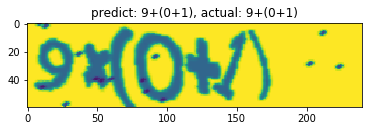

In [27]:
plt.imshow(batch_x[0][:,:,0])
decoded = ''.join([decode_maps[i] for i in decoded[:,0] if i not in [0,1,2]])
actual = ''.join([decode_maps[i] for i in batch_y[0] if i not in [0,1,2]])
plt.title('predict: %s, actual: %s'%(decoded, actual))
plt.show()